# Task 2 : Sydney Dataset

Maxime TCHIBOZO

In [246]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import category_encoders as ce

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

import warnings

Disclaimer : to ensure reproducibility of results, please make sure the csv file containing the dataset is named "sydney-data.csv"

In [247]:
df = pd.read_csv("sydney-data.csv")
print("The shape of the full dataframe is : "+str(np.shape(df)))

The shape of the full dataframe is : (4600, 18)


## 2.1 Drop Invalid rows, determine continuous and categorical features

In [248]:
#We drop the rows whose price is equal to 0
df = df[df["price"] != 0]

#We remove the date column
df = df.drop(["date"],axis=1)

print("The shape of the dataframe when we remove date and rows with price = 0 is : "+str(np.shape(df)))
df.head()

The shape of the dataframe when we remove date and rows with price = 0 is : (4551, 17)


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


The continuous features are : sqft_living, sft_lot,sqft_above, sqft_basement.

The target: price is continuous.

The categorical features are : bedrooms, bathrooms, floors, waterfront, view, condition, yr_built, yr_renovated, street, city, and statezip.

In [249]:
df["country"].unique()

array(['USA'], dtype=object)

All of the data comes from the same country : USA, so we can remove the country column (it does not add any information on price).

In [250]:
df = df.drop(["country"],axis=1)

## 2.2 Distribution of continuous features, Distribution of target

Text(0, 0.5, 'count')

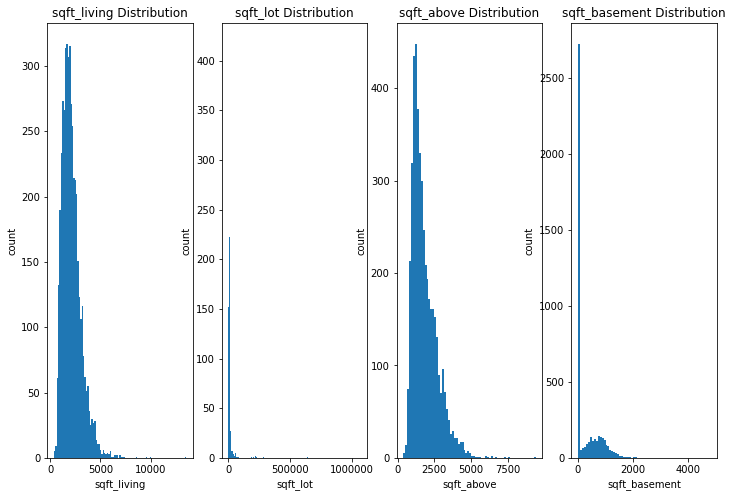

In [251]:
#Distribution of the continuous features
fig, ax = plt.subplots(1,4,figsize=(12,8))

ax[0].hist(df["sqft_living"],bins="auto")
ax[0].title.set_text("sqft_living Distribution")
ax[0].set_xlabel("sqft_living")
ax[0].set_ylabel("count")

ax[1].hist(df["sqft_lot"],bins="auto")
ax[1].title.set_text("sqft_lot Distribution")
ax[1].set_xlabel("sqft_lot")
ax[1].set_ylabel("count")

ax[2].hist(df["sqft_above"],bins="auto")
ax[2].title.set_text("sqft_above Distribution")
ax[2].set_xlabel("sqft_above")
ax[2].set_ylabel("count")

ax[3].hist(df["sqft_basement"],bins="auto")
ax[3].title.set_text("sqft_basement Distribution")
ax[3].set_xlabel("sqft_basement")
ax[3].set_ylabel("count")



Text(0, 0.5, 'count')

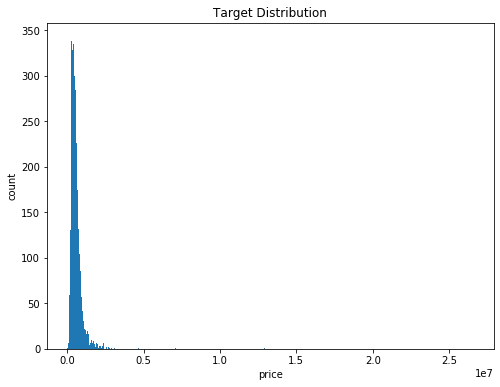

In [252]:
#Distribution of the target
plt.figure(figsize=(8,6))
plt.hist(df["price"],bins="auto")
plt.title("Target Distribution")
plt.xlabel("price")
plt.ylabel("count")


Judging by the empirical distribution of price, and the four categorical features, there are outliers which might have to be removed in order for our analysis to be accurate. It is worth noting that we have already removed rows with price=0. 
Additionally, the sqft_lot and sqft_basement features have peaks at 0. 
Going forward, we will remove the outliers on price.

## 2.3 Target-Feature pairwise plots

Text(0, 0.5, 'price')

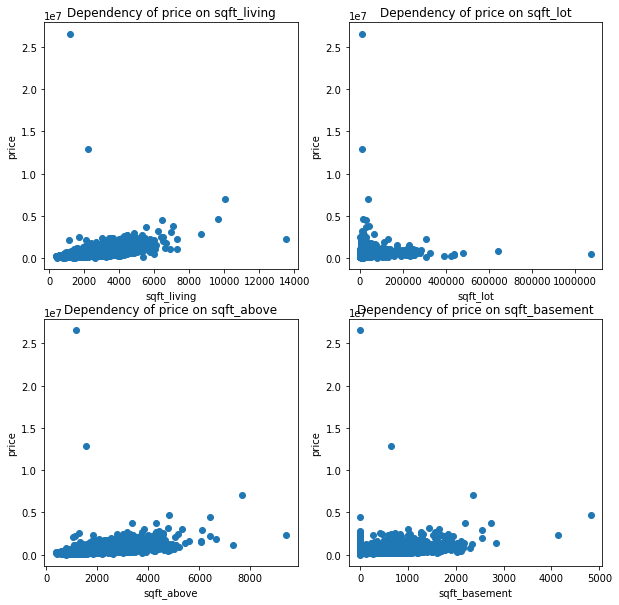

In [253]:
#We plot the dependency of plot 
fig, ax = plt.subplots(2,2,figsize=(10,10))

ax[0,0].scatter(df["sqft_living"],df["price"])
ax[0,0].title.set_text("Dependency of price on sqft_living")
ax[0,0].set_xlabel("sqft_living")
ax[0,0].set_ylabel("price")

ax[0,1].scatter(df["sqft_lot"],df["price"])
ax[0,1].title.set_text("Dependency of price on sqft_lot")
ax[0,1].set_xlabel("sqft_lot")
ax[0,1].set_ylabel("price")

ax[1,0].scatter(df["sqft_above"],df["price"])
ax[1,0].title.set_text("Dependency of price on sqft_above")
ax[1,0].set_xlabel("sqft_above")
ax[1,0].set_ylabel("price")

ax[1,1].scatter(df["sqft_basement"],df["price"])
ax[1,1].title.set_text("Dependency of price on sqft_basement")
ax[1,1].set_xlabel("sqft_basement")
ax[1,1].set_ylabel("price")

It seems that there is a positive correlation between price and each of the sqft variables. Let us remove the outliers to confirm this hypothsis.

Text(0, 0.5, 'price')

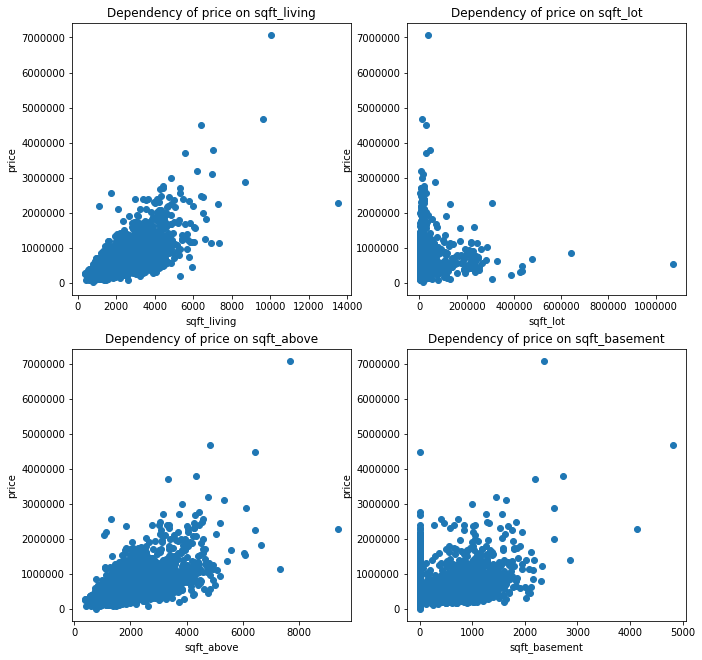

In [254]:
df_outlier_removed = df[df["price"] < 1e7]

fig, ax = plt.subplots(2,2,figsize=(11,11))

ax[0,0].scatter(df_outlier_removed["sqft_living"],df_outlier_removed["price"])
ax[0,0].title.set_text("Dependency of price on sqft_living")
ax[0,0].set_xlabel("sqft_living")
ax[0,0].set_ylabel("price")

ax[0,1].scatter(df_outlier_removed["sqft_lot"],df_outlier_removed["price"])
ax[0,1].title.set_text("Dependency of price on sqft_lot")
ax[0,1].set_xlabel("sqft_lot")
ax[0,1].set_ylabel("price")

ax[1,0].scatter(df_outlier_removed["sqft_above"],df_outlier_removed["price"])
ax[1,0].title.set_text("Dependency of price on sqft_above")
ax[1,0].set_xlabel("sqft_above")
ax[1,0].set_ylabel("price")

ax[1,1].scatter(df_outlier_removed["sqft_basement"],df_outlier_removed["price"])
ax[1,1].title.set_text("Dependency of price on sqft_basement")
ax[1,1].set_xlabel("sqft_basement")
ax[1,1].set_ylabel("price")

Removing the outliers confirms the hypothesis that price is positively correlated with the four sqft features. In the cases of sqft_living and sqft_above, the correlation is strong, and it would be appropriate to model the data with Least Squares Linear Regression.

# 2.4 Train-test split and preprocessing pipeline

Analyzing the .dat file data reveals that the yr_renovated column has NaN values. In the .csv file, these NaN values have been replaced by zeros. We will set them back to np.nan and apply a simple median imputer to the yr_renovated column. We choose the median as the median of the years will always be an integer value. This will help us when we encode the yr_renovated column as a categorical variable.

In [255]:
df['yr_renovated'].mask(df['yr_renovated'] == 0, np.nan, inplace=True)
df['yr_renovated'].head()

0    2005.0
1       NaN
2       NaN
3       NaN
4    1992.0
Name: yr_renovated, dtype: float64

In [256]:
#We preprocess the data without scaling
warnings.filterwarnings('ignore')

df = df_outlier_removed[df_outlier_removed.columns.difference(["price","sqft_living","sqft_lot","sqft_above","sqft_basement"])].astype("object")
df = pd.concat([df,df_outlier_removed[["sqft_living","sqft_lot","sqft_above","sqft_basement"]].astype("float")],axis=1)

categorical = df.dtypes == object

preprocess_unscaled = make_column_transformer((SimpleImputer(strategy="median"),["yr_renovated"]),(ce.OneHotEncoder(), categorical),("passthrough",~categorical))

X_train, X_test, y_train, y_test = train_test_split(df,df_outlier_removed["price"])

model_lin_reg = make_pipeline(preprocess_unscaled, LinearRegression())
model_lasso = make_pipeline(preprocess_unscaled, Lasso())
model_ridge = make_pipeline(preprocess_unscaled,Ridge())
model_elastic_net = make_pipeline(preprocess_unscaled,ElasticNet())

scores_lin_reg = np.mean(cross_val_score(model_lin_reg, X_train, y_train))
scores_lasso = np.mean(cross_val_score(model_lasso,X_train,y_train))
scores_ridge = np.mean(cross_val_score(model_ridge,X_train,y_train))
scores_elastic_net = np.mean(cross_val_score(model_elastic_net,X_train,y_train))

print("Linear Regression without scaling Score : "+str(scores_lin_reg))
print("Lasso without scaling Score : "+str(scores_lasso))
print("Ridge without scaling Score : "+str(scores_ridge))
print("Elastic Net without scaling Score : "+str(scores_elastic_net))


Linear Regression without scaling Score : -59.89561228919964
Lasso without scaling Score : 0.4687220016349805
Ridge without scaling Score : 0.7223574662665617
Elastic Net without scaling Score : 0.5463439805193165


In [257]:
#We preprocess the data with scaling
warnings.filterwarnings('ignore')

df = df_outlier_removed[df_outlier_removed.columns.difference(["price","sqft_living","sqft_lot","sqft_above","sqft_basement"])].astype("object")
df = pd.concat([df,df_outlier_removed[["sqft_living","sqft_lot","sqft_above","sqft_basement"]].astype("float")],axis=1)

categorical = df.dtypes == object

preprocess_scaled = make_column_transformer((SimpleImputer(strategy="median"),["yr_renovated"]),(ce.OneHotEncoder(), categorical),(StandardScaler(),~categorical))

X_train, X_test, y_train, y_test = train_test_split(df,df_outlier_removed["price"])

model_lin_reg = make_pipeline(preprocess_scaled, LinearRegression())
model_lasso = make_pipeline(preprocess_scaled, Lasso())
model_ridge = make_pipeline(preprocess_scaled,Ridge())
model_elastic_net = make_pipeline(preprocess_scaled,ElasticNet())

scores_lin_reg = np.mean(cross_val_score(model_lin_reg, X_train, y_train))
scores_lasso = np.mean(cross_val_score(model_lasso,X_train,y_train))
scores_ridge = np.mean(cross_val_score(model_ridge,X_train,y_train))
scores_elastic_net = np.mean(cross_val_score(model_elastic_net,X_train,y_train))

print("Linear Regression with scaling Score : "+str(scores_lin_reg))
print("Lasso with scaling Score : "+str(scores_lasso))
print("Ridge with scaling Score : "+str(scores_ridge))
print("Elastic Net with scaling Score : "+str(scores_elastic_net))


Linear Regression with scaling Score : -7917.8215704149015
Lasso with scaling Score : 0.3756445427070364
Ridge with scaling Score : 0.7363816409099707
Elastic Net with scaling Score : 0.5306898757486109


Scaling does not improve results, so we will not use scaling going forward.

## 1.5 Tuning the parameters

In [258]:
#We Dummy encode the categorical variables, impute yr_renovated and train-test split

df = df_outlier_removed[df_outlier_removed.columns.difference(["price","sqft_living","sqft_lot","sqft_above","sqft_basement"])].astype("object")
df = pd.concat([df,df_outlier_removed[["sqft_living","sqft_lot","sqft_above","sqft_basement"]].astype("float")],axis=1)

categorical = df.dtypes == object

preprocess_scaled = make_column_transformer((SimpleImputer(strategy="median"),["yr_renovated"]),(ce.OneHotEncoder(), categorical),("passthrough",~categorical))

df = make_pipeline(preprocess_scaled).fit_transform(df)

X_train,X_test,y_train,y_test = train_test_split(df,df_outlier_removed["price"])
X_train_2,X_validate,y_train_2,y_validate = train_test_split(X_train,y_train)

print("After dummy encoding and median imputing, X_train has the following shape : "+str(np.shape(X_train)))

After dummy encoding and median imputing, X_train has the following shape : (3411, 4828)


Dummy encoding all the categorical variables has created $\approx$ 4800 more features. This explains why our Linear Regression Model performs so badly. For OLS, we need to have more rows than we have features.

In [259]:
#warnings.filterwarnings('ignore')

pipe = Pipeline([("regressor",LinearRegression())])

param_grid = [{'regressor': [LinearRegression()]},
              {'regressor': [Lasso()],
               'regressor__alpha':np.logspace(-3,3,10)},
              {'regressor': [Ridge()],
              'regressor__alpha':np.logspace(-3,3,10)},
              {'regressor': [ElasticNet()],
              'regressor__alpha':np.logspace(-3,3,10),
              'regressor__l1_ratio':np.logspace(-3,0,10)}]

grid = GridSearchCV(pipe, param_grid,cv=5)
grid.fit(X_train_2,y_train_2)

print("Best model based on training : "+ str(grid.best_params_))
print("Score of best model on test : "+str(grid.score(X_validate,y_validate)))


Best model based on training : {'regressor': Lasso(alpha=215.44346900318823, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'regressor__alpha': 215.44346900318823}
Score of best model on test : 0.7583617978140507


Parameter Tuning improves results of the best regressor. The best model is a Lasso with alpha=215.
Let us now see how the validation scores depend on the parameters

In [260]:
#We compute the dependence of validation scores on parameters for Lasso and Ridge
Lasso_params = np.logspace(-3,3,10)
Lasso_vals = [Lasso(alpha=Lasso_params[i]).fit(X_train_2,y_train_2).score(X_validate,y_validate) for i in range(len(Lasso_params))]

Ridge_params = np.logspace(-3,3,10)
Ridge_vals = [Ridge(alpha=Ridge_params[i]).fit(X_train_2,y_train_2).score(X_validate,y_validate) for i in range(len(Lasso_params))]

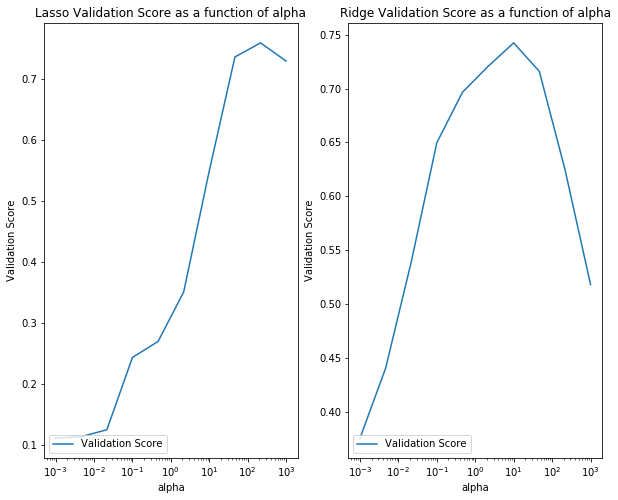

In [261]:
fig, ax = plt.subplots(1,2,figsize=(10,8))

ax[0].plot(Lasso_params,Lasso_vals,label="Validation Score")
ax[0].set_xlabel("alpha")
ax[0].set_xscale("log")
ax[0].set_ylabel("Validation Score")
ax[0].title.set_text("Lasso Validation Score as a function of alpha")
ax[0].legend(loc="lower left")

ax[1].plot(Ridge_params,Ridge_vals,label="Validation Score")
ax[1].set_xlabel("alpha")
ax[1].set_xscale("log")
ax[1].set_ylabel("Validation Score")
ax[1].title.set_text("Ridge Validation Score as a function of alpha")
ax[1].legend(loc="lower left")



In [267]:
#We compute the dependence of validation scores on parameters for ElasticNet

from mpl_toolkits.mplot3d import Axes3D

x = np.logspace(-3,3,10)
y = np.logspace(-3,0,10)
xx, yy = np.meshgrid(x, y, sparse=False, indexing='xy')
zz = np.zeros((10,10))

for i in range(10):
    for j in range(10):
        zz[i,j] = ElasticNet(alpha=xx[i,j],l1_ratio=yy[i,j]).fit(X_train_2,y_train_2).score(X_validate,y_validate)

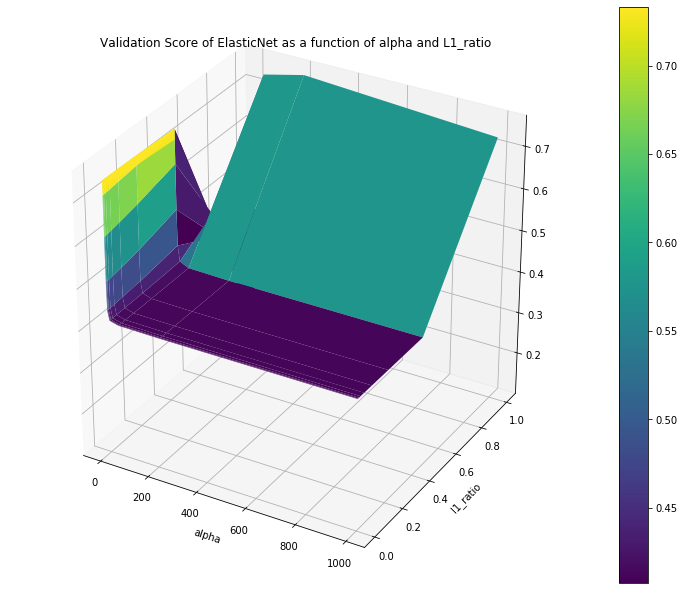

In [273]:
#We plot the dependence of validation scores
%matplotlib inline

fig = plt.figure(figsize=(10,8))
ax = Axes3D(fig)

surf = ax.plot_surface(xx,yy,zz,cmap='viridis')
plt.ylabel('l1_ratio')
plt.xlabel('alpha')
plt.title('Validation Score of ElasticNet as a function of alpha and L1_ratio')
fig.colorbar(surf)

## 2.6 20 Most important coefficients of each model

In [264]:
#We first select satisfactory parameters for each model

#Linear Regression
model_LR = LinearRegression().fit(X_train,y_train)

#Lasso Regression
pipe = Pipeline([('regressor',Lasso())])

param_grid = [{'regressor': [Lasso()],
               'regressor__alpha':np.logspace(-3,3,10)}]

grid = GridSearchCV(pipe, param_grid)
grid.fit(X_train,y_train)

model_Lasso = Lasso(alpha = grid.best_params_["regressor__alpha"]).fit(X_train,y_train)

#Ridge Regression
pipe = Pipeline([('regressor',Ridge())])

param_grid = [{'regressor': [Ridge()],
               'regressor__alpha':np.logspace(-3,3,10)}]

grid = GridSearchCV(pipe, param_grid)
grid.fit(X_train,y_train)

model_Ridge = Ridge(alpha = grid.best_params_["regressor__alpha"]).fit(X_train,y_train)

#ElasticNet Regression
pipe = Pipeline([('regressor',ElasticNet())])

param_grid = [{'regressor': [ElasticNet()],
               'regressor__alpha':np.logspace(-3,3,10),
               'regressor__l1_ratio':np.logspace(-3,0,10)}]

grid = GridSearchCV(pipe, param_grid)
grid.fit(X_train,y_train)

model_Elastic_Net = ElasticNet(alpha = grid.best_params_["regressor__alpha"],l1_ratio=grid.best_params_["regressor__l1_ratio"]).fit(X_train,y_train)


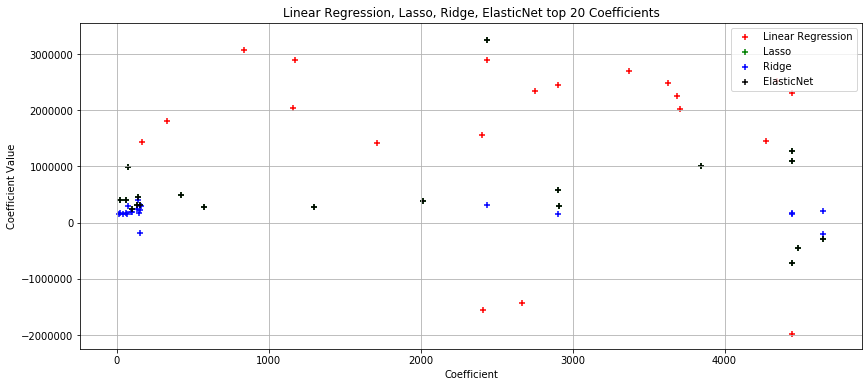

In [271]:
%matplotlib inline
#We select the 20 most important coefficients (i.e those with largest absolute value) for Logistic Regression
coef_LR = np.absolute(model_LR.coef_)
coef_LR = np.argsort(coef_LR) #sorts from smallest to largest
coef_LR = np.flip(coef_LR)[:20] #selects 20 most important coefs

coef_Lasso = np.absolute(model_Lasso.coef_)
coef_Lasso = np.argsort(coef_Lasso) 
coef_Lasso = np.flip(coef_Lasso)[:20] 

coef_Ridge = np.absolute(model_Ridge.coef_)
coef_Ridge = np.argsort(coef_Ridge) 
coef_Ridge = np.flip(coef_Ridge)[:20] 

coef_Elastic_Net = np.absolute(model_Elastic_Net.coef_)
coef_Elastic_Net = np.argsort(coef_Elastic_Net) 
coef_Elastic_Net = np.flip(coef_Elastic_Net)[:20] 


plt.figure(figsize=(14,6))

plt.xlabel("Coefficient")
plt.ylabel("Coefficient Value")
plt.grid()

plt.scatter(coef_LR,[model_LR.coef_[i] for i in coef_LR],marker="+",c="r",label="Linear Regression")
plt.scatter(coef_Lasso,[model_Lasso.coef_[i] for i in coef_Lasso],marker="+",c="g",label="Lasso")
plt.scatter(coef_Ridge,[model_Ridge.coef_[i] for i in coef_Ridge],marker="+",c="b",label="Ridge")
plt.scatter(coef_Elastic_Net,[model_Elastic_Net.coef_[i] for i in coef_Elastic_Net],marker="+",c="k",label="ElasticNet")
plt.title("Linear Regression, Lasso, Ridge, ElasticNet top 20 Coefficients")
plt.legend(loc="upper right")

plt.show()

The order of magnitude of the coefficients is $10^6$, which is the same order of magnitude that price has. This indicates that our models have not overfitted.

The plot indicates that some of the coefficients are aligned on the same x (coefficient) values. This means that the models have selected the same features. Let us confirm this by looking directly at the top 20 coefficients.

In [272]:
print("Linear Regression Coefs : "+str(np.sort(coef_LR)))
print("Lasso Coefs : "+str(np.sort(coef_Lasso)))
print("Ridge Coefs : "+str(np.sort(coef_Ridge)))
print("Elastic Net Coefs : "+str(np.sort(coef_Elastic_Net)))

Linear Regression Coefs : [ 170  331  836 1161 1173 1713 2407 2414 2439 2670 2753 2902 3370 3627
 3689 3706 4276 4343 4446 4447]
Lasso Coefs : [  20   64   74  101  135  139  153  421  573 1296 2018 2439 2902 2913
 3847 4445 4446 4447 4481 4648]
Ridge Coefs : [  16   20   40   64   67   74   93  101  135  139  149  153  157  163
 2439 2902 4445 4446 4648 4649]
Elastic Net Coefs : [  20   64   74  101  135  139  153  421  573 1296 2018 2439 2902 2913
 3847 4445 4446 4447 4481 4648]


The top 20 coefficients in all 4 models are similar. The top 20 coefficients for Lasso, Ridge and ElasticNet are almost identical.